In [1]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(broom)
library(digest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Methods and Results
## ANOVA Test for three different wine rating groups
After careful analysis and discussion, we decided to apply ANOVA test first instead of multiple pair-wise tests in order to reduce the overlapping and error that is caused by multiple random selections. We will focus on the variance in and between each sample group (analysis of variance) to test if the variation between treatments or MST can be fully explained by the random nature of the data or variation within each treatment (MSE). If we get a large F-value, that means MST is much larger than MSE and the null hypothesis is false. If we get am F-value which is approaching zero, that means MST can be fully explained by MSE and we will fail to reject the null hypothesis.
<br>
Our null hypothesis:
The volatile acidity level (g/dm^3) in 5-ratings group, 6-ratings group, and 7-ratings group is the same.
<br>
Our alternative hypothesis here is:
There is at least one group among the three groups whose volatile acidity level is different from others'.
<br>
We choose 0.05 as our significant(alpha) value.
<br>
Below is the code and the ANOVA table.

In [2]:
## filter and achieve the specific 3 rating groups data
wine_data_filtered <- read.csv("https://raw.githubusercontent.com/sonatuna/Group_25_Project/main/winequality-red.csv", sep = ";") |>
    mutate(quality = as.factor(quality)) |>
    filter(quality %in% c('5','6','7'))
## perform ANOVA test
anova_result <- aov(volatile.acidity ~ quality, data = wine_data_filtered)
## diplay the ANOVA table
summary(anova_result)

              Df Sum Sq Mean Sq F value Pr(>F)    
quality        2   5.22  2.6097     101 <2e-16 ***
Residuals   1515  39.15  0.0258                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Df (Degrees of Freedom):
    * quality: This has 5 degrees of freedom. Since we have 3 quality rating groups, the degrees of freedom is 3-1 = 2.
    * Residuals: The residual degrees of freedom is 1515. This is calculated as the total number of observations minus the number of groups.
### Sum Sq (Sum of Squares):
    * quality: The variance that can be explained by differences between the quality groups is 5.22.
    * Residuals: The variance that cannot be explained by the quality groups and is due to individual differences or errors is 39.15.
### Mean Sq (Mean Squares):
    * quality: This is the explained variance (5.22) divided by its degrees of freedom (2), which equals 2.6097.
    * Residuals: This is the unexplained variance (39.01) divided by its degrees of freedom (1515), which equals 0.0258.
### F value:
    * The computed F-value is 101. It represents the ratio of explained variance to unexplained variance. A high F-value indicates that the group means are not all equal. Usually if the ratio is equal to one, it indicates that the variance can be fully explained by random selection error.
* 		Pr(>F):
    * This is the p-value associated with the F-statistic, and it's less than 2e-16 (essentially 0), which is much less than 0.05 (the alpha level). This means that the result is statistically significant at the 0.05 level (or even at much stricter levels like 0.01 or 0.001).
### Signif. codes:
    * The asterisks (*** in this case) indicate the level of significance. Three asterisks denote a very significant p-value (p < 0.001).
    * 

### Conclusion:
<br>
The ANOVA test indicates a significant difference in volatile acidity across the different quality ratings of wine. Given the extremely low p-value, we can reject the null hypothesis. This is strong evidence to suggest that at least one quality rating group have different mean volatile acidity level compared with others.

## Multiple pairwise tests
Based on the conclusion from the ANOVA test, our next step is to perform multiple pair-wise tests to determine which group's acidity level is different from the others. In total, we are going to perform pairwise tests three times: 5-rating group VS 6-rating group; 6-rating group VS 7-rating group; 5-rating group VS 7-rating group.
<br>
We will explain the first test in detail, then briefly summarize the rest two since the process is highly repetitive.

### 5-rating group VS 6-rating group
We want to compare 5-rating group with 6-rating group to see if there is a statistically significant difference between these two groups in the level of volatile acidity.
<br>
Null hypothesis: The level of volatile acidity between these two groups are the same.
<br>
Alternative hypothesis: The level of volatile acidity between these two groups differ.
<br>
Siginificance level: 0.05
<br>
First, we calculate the observed difference in means.

In [3]:
obs_diff_in_means <- wine_data_filtered |>
    filter(quality %in% c('5', '6')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("5", "6"))
obs_diff_in_means

Dropping unused factor levels c("3", "4", "7", "8") from the supplied explanatory variable 'quality'.



stat
<dbl>
0.07955679


Then, using permutation, we generate a null model(distribution) assuming our null hypothesis is true. To make our analysis reproducible, we set a seed here (also for the rest two tests).

In [4]:
set.seed(2023)
null_model_acidity <- 
    wine_data_filtered|>
    filter(quality %in% c('5', '6')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("5", "6"))
head(null_model_acidity)

Dropping unused factor levels c("3", "4", "7", "8") from the supplied explanatory variable 'quality'.



replicate,stat
<int>,<dbl>
1,-0.006007991
2,0.004131671
3,-0.009757237
4,0.001945875
5,-0.007222322
6,-0.001120310


## Visulization of null model, observed difference in means, and confidence interval
We visualized the null distribution and the observed difference in means. We have also created a visualize of the 95% confidence interval to help our audience to form a good understanding the relation between the null distribution and the observed difference.

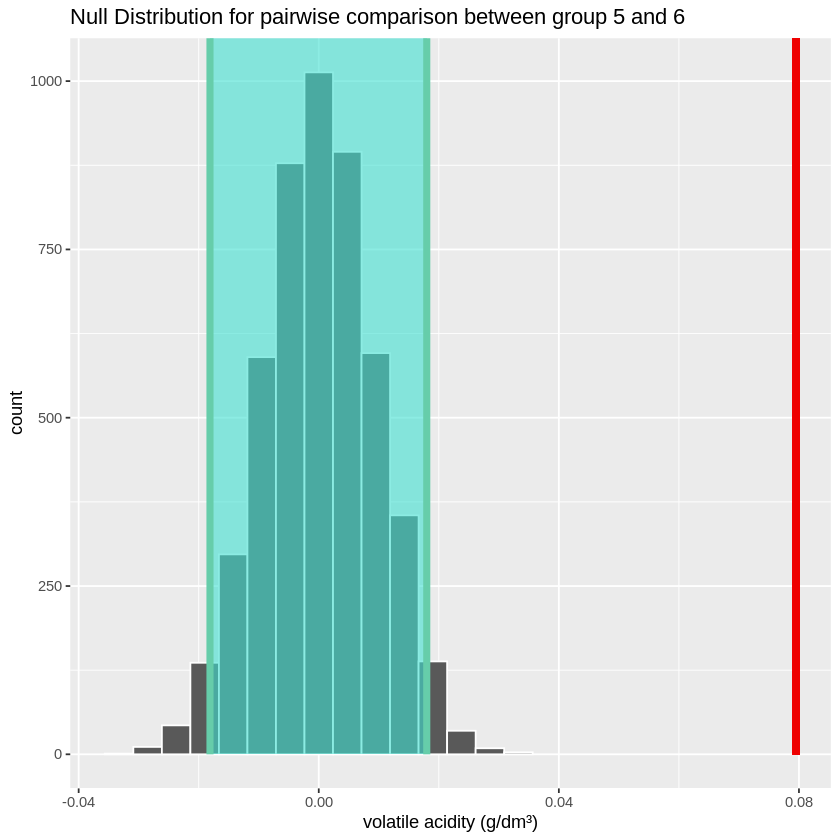

In [11]:
first_null_ci <- 
    null_model_acidity %>% 
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))
acidity_result_plot <- 
   null_model_acidity %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means, direction = "both") +
   xlab('volatile acidity (g/dm³)') +
    ggtitle("Null Distribution for pairwise comparison between group 5 and 6") +
    shade_confidence_interval(endpoints = first_null_ci)

acidity_result_plot

The histogram is the null distribution generated by permutation and the red line indicates the observed difference in means(of the rating groups). Therefore, we suspect that it is very unlikely to get the observed difference in means assuming that the null hypothesis is true. To prove our suspection, we need to calculate the p-value and compare it with our significance level.

In [6]:
p_value <- null_model_acidity |>
   get_p_value(obs_stat = obs_diff_in_means, direction = "both")
p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


## P-Correction
Since we are more likely to commit a Type I error as we will test three hypotheses in total. We want to use the Bonferroni adjustment to reduce the likelihood of committing a Type I error.

In [7]:
p_value_adjusted <- p.adjust(p_value, method = "bonferroni")
p_value_adjusted

p_value 
      0

It is obvious that the p-value is sigificantly smaller than our siginicance level (0.05). Hence, we have evidence to reject the null hypothesis and conclude that there is a statiscally siginificant difference between the means of 5-rating group and 6-rating group.
## Two Sample t-test

We also performed a two sample t-test to make sure that our conclusion is robust and accurate since the p-value we got previously is extremely small. 

In [8]:
first_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "5") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "6") |> pull(volatile.acidity)))
first_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.07955679,0.5770411,0.4974843,8.867539,2.384872e-18,1314.712,0.0619564,0.09715718,Welch Two Sample t-test,two.sided


## The rest two Pairwise tests: 6-rating group vs 7-rating group; 5-rating group vs 7-rating group
We follow the same procedure fot these two tests.
<br>
<br>
Our null hypothesis: The level of volatile acidity between 6-rating group and 7-rating group are the same;
<br>
The level of volatile acidity between 5-rating group and 7-rating group are the same.
<br>
<br>
Our alternative hypothesis: The level of volatile acidity between 6-rating group and 7-rating group are different;
<br>
The level of volatile acidity between 5-rating group and 7-rating group are different.
<br>
<br>
Siginificance level: 0.05


Dropping unused factor levels c("3", "4", "5", "8") from the supplied explanatory variable 'quality'.



stat
<dbl>
0.09356473


Dropping unused factor levels c("3", "4", "5", "8") from the supplied explanatory variable 'quality'.



replicate,stat
<int>,<dbl>
1,-0.014288960
2,0.006081938
3,0.012147060
4,0.012081135
5,0.018508845
6,0.009015611


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


p_value
<dbl>
0


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.09356473,0.4974843,0.4039196,7.727874,1.08632e-13,362.2767,0.06975505,0.1173744,Welch Two Sample t-test,two.sided


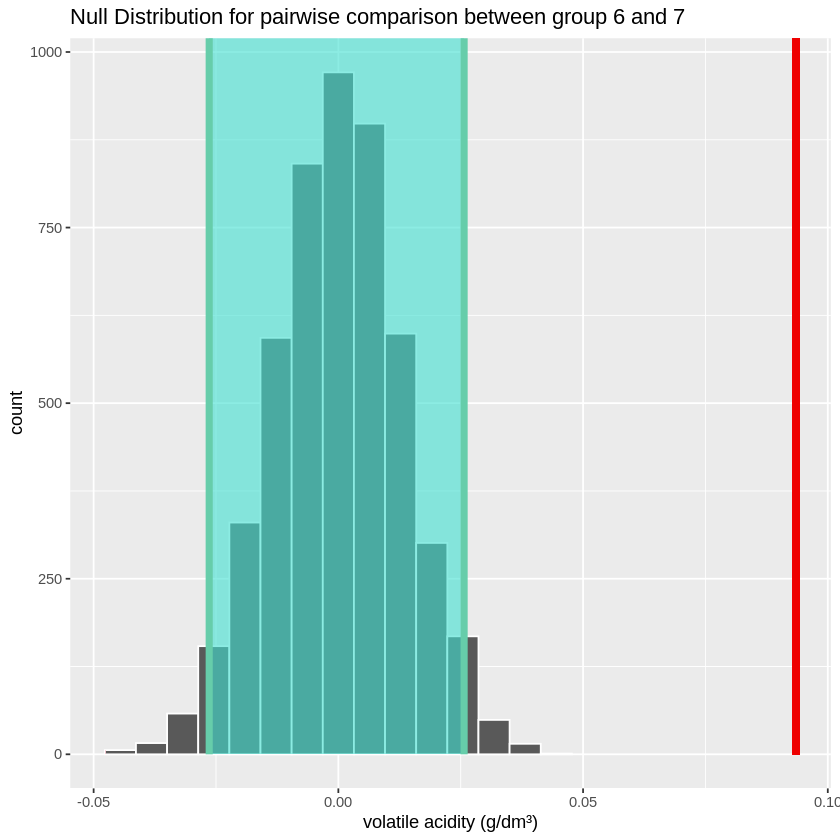

In [12]:
## 6-rating group vs 7-rating group
set.seed(2023)
obs_diff_in_means_2 <- wine_data_filtered |>
    filter(quality %in% c('6', '7')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("6", "7"))
obs_diff_in_means_2
null_model_acidity_2 <- 
    wine_data_filtered|>
    filter(quality %in% c('6', '7')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("6", "7"))
head(null_model_acidity_2)
second_null_ci <- 
    null_model_acidity_2 %>% 
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))
acidity_result_plot_2 <- 
   null_model_acidity_2 %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means_2, direction = "both") +
   xlab('volatile acidity (g/dm³)') +
    ggtitle("Null Distribution for pairwise comparison between group 6 and 7") +
    shade_confidence_interval(endpoints = second_null_ci)

acidity_result_plot_2
p_value_2 <- null_model_acidity_2 |>
   get_p_value(obs_stat = obs_diff_in_means_2, direction = "both")
p_value_2
p_value_adjusted_2 <- p_value_2 * 3
p_value_adjusted_2
second_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "6") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "7") |> pull(volatile.acidity)))
second_t_test

Dropping unused factor levels c("3", "4", "6", "8") from the supplied explanatory variable 'quality'.



stat
<dbl>
0.1731215


Dropping unused factor levels c("3", "4", "6", "8") from the supplied explanatory variable 'quality'.



replicate,stat
<int>,<dbl>
1,0.0242892510
2,0.0007501162
3,0.0187697297
4,0.0165294534
5,0.0205879249
6,-0.0009706757


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


p_value
<dbl>
0


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1731215,0.5770411,0.4039196,14.33441,3.445569e-37,360.2057,0.1493706,0.1968725,Welch Two Sample t-test,two.sided


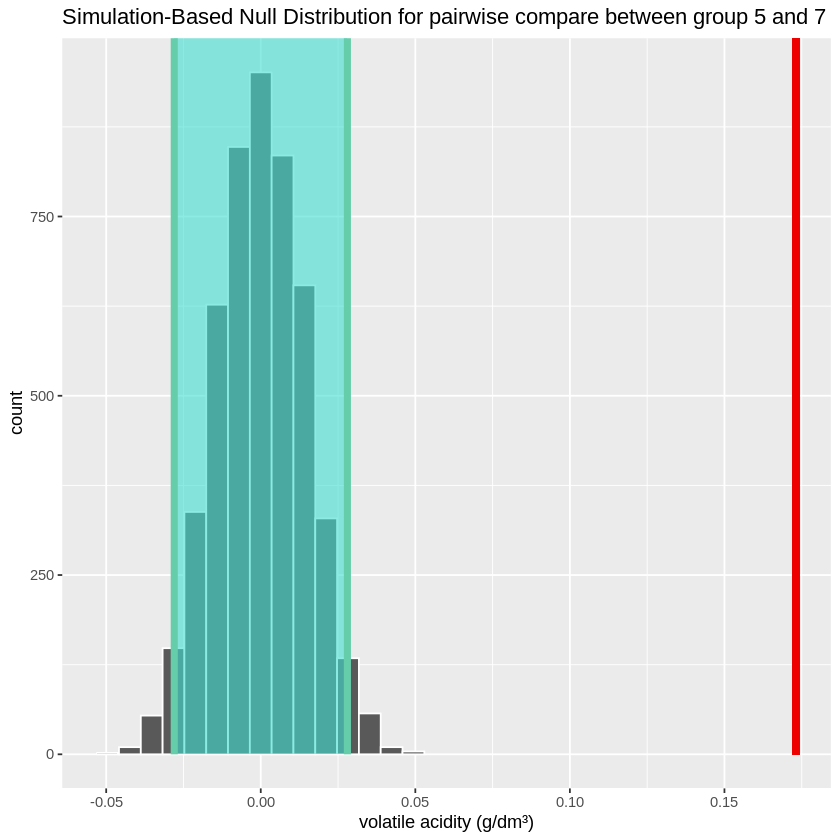

In [13]:
set.seed(2023)
obs_diff_in_means_3 <- wine_data_filtered |>
    filter(quality %in% c('5', '7')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("5", "7"))
obs_diff_in_means_3
null_model_acidity_3 <- 
    wine_data_filtered|>
    filter(quality %in% c('5', '7')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("5", "7"))
head(null_model_acidity_3)
third_null_ci <- 
    null_model_acidity_3 %>% 
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))
acidity_result_plot_3 <- 
   null_model_acidity_3 %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means_3, direction = "both") +
   xlab('volatile acidity (g/dm³)') +
    ggtitle("Simulation-Based Null Distribution for pairwise compare between group 5 and 7") +
    shade_confidence_interval(endpoints = third_null_ci)

acidity_result_plot_3
p_value_3 <- null_model_acidity_3 |>
   get_p_value(obs_stat = obs_diff_in_means_3, direction = "both")
p_value_3
p_value_adjusted_3 <- p_value_3 * 3
p_value_adjusted_3
third_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "5") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "7") |> pull(volatile.acidity)))
third_t_test

Both tests' plots indicate that observed difference in means is very unlikely to obtain and the p-values that we get from bootstrap and two sample t-test are all approaching zero. We can conclude that 6-rating group's acidity level is different from 7-rating group's acidity level, and 5-rating group's acidity level is different from 7-rating group's acidity level too.

## conclusion of results
We have strong evidences indicating that all of the three groups' acidity level is statiscally and significantly different from each other. As we take a further look at the three plots and test results provided by the t-tests above, we suspect that among the three different rating groups, the 5-rating group have the highest volatile acidity level while the 6-rating group have the smallest volatile acidity level. That being said, this is only an educated assumption. We used both bootstrap and asymptotic approaches in our methods, and produced a similar conclusion in each. However, we believe that the bootstrap approach is a better fit in our case as our sample size for different rating groups varies a lot, and bootstrap may perform better for small sample sizes and non-standard dsitributions since it does not rely on strong assumptions about the data (such as assuming the data follows a t-distribution).

# Discussion

In this study, we first conducted an ANOVA test, which then conducting the pair-wise t-tests for the rating groups 5, 6, and 7, we obtained a p value of 0 for each of the groups and evidently rejected the null hypothesis, "there is no difference in volatile acidity levels between the quality ratings 5, 6, and 7". Moreover, while not explicitly concluded this study, the differing VA levels in our findings helps support the theory that higher wine quality contains lower VA. These results may validate the higher price of expensive wines due to higher quality, and provide insight for consumer choices. The fact that VA levels differ for quality align with research, so it is what we expected to find. In fact, we obtained near zero p-values, which was very ideal and exceeded our expectations. One extension to this study is to build a predictive model to predict quality rating and utilize our findings in this study to decide if volatile acidity is a significant predictor or not.